In [100]:
import pytz
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipline.algorithm import TradingAlgorithm
from zipline.transforms import MovingAverage, batch_transform
from zipline.finance import trading
from zipline.utils.factory import create_returns_from_list
from zipline.finance.risk import RiskReport

In [90]:
class DualMovingAverage(TradingAlgorithm):
    """Dual Moving Average Crossover algorithm.
    
    This algorithm buys apple once its short moving average crosses
    its long moving average (indicating upwards momentum) and sells
    its shares once the averages cross again (indicating downwards
    momentum).
    
    """
    def initialize(self, short_window=10, long_window=20):
        # Add 2 mavg transforms, one with a long window, one
        # with a short window.
        self.add_transform(MovingAverage, 'short_mavg', ['open'],
                           window_length=short_window)

        self.add_transform(MovingAverage, 'long_mavg', ['open'],
                           window_length=long_window)

        # To keep track of whether we invested in the stock or not
        self.invested = False

    def handle_data(self, data):
        self.short_mavg = data['BTC'].short_mavg['open']
        self.long_mavg = data['BTC'].long_mavg['open']
        self.buy = False
        self.sell = False

        if self.short_mavg > self.long_mavg and not self.invested:
            print "{dt}: Buying 100 BTC shares.".format(dt=data['BTC'].datetime)
            self.order('BTC', 100)
            self.invested = True
            self.buy = True
        elif self.short_mavg < self.long_mavg and self.invested:
            print "{dt}: Selling 100 BTC shares.".format(dt=data['BTC'].datetime)
            self.order('BTC', -100)
            self.invested = False
            self.sell = True

        self.record(short_mavg=self.short_mavg,
                    long_mavg=self.long_mavg,
                    buy=self.buy,
                    sell=self.sell)

In [93]:
data = OrderedDict()
#data['BTC'] = pd.DataFrame.from_csv('http://www.quandl.com/api/v1/datasets/BITCOIN/MTGOXUSD.csv?trim_start=2012-01-01&sort_order=asc'
df = pd.read_csv("http://api-twistedogic01.rhcloud.com/api/hist/0700.HK", index_col='Date', parse_dates=True)
df['Price'] = df['Close']
data['BTC'] = df.drop(df.tail(1).index)
data['BTC'] = data['BTC'].rename(columns={'Price': 'price', 
                                          'High':'high', 
                                          'Low':'low', 
                                          'Open':'open', 
                                          'Close':'close',
                                          'Volume':'volume'
                                          })
data['BTC'] = data['BTC'].fillna(method='ffill')
data['BTC'] = data['BTC'].tail(300)
panel = pd.Panel(data)
panel.minor_axis = ['Symbol','open', 'high', 'low', 'close', 'volume', 'price']
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)


In [ ]:
data['BTC']

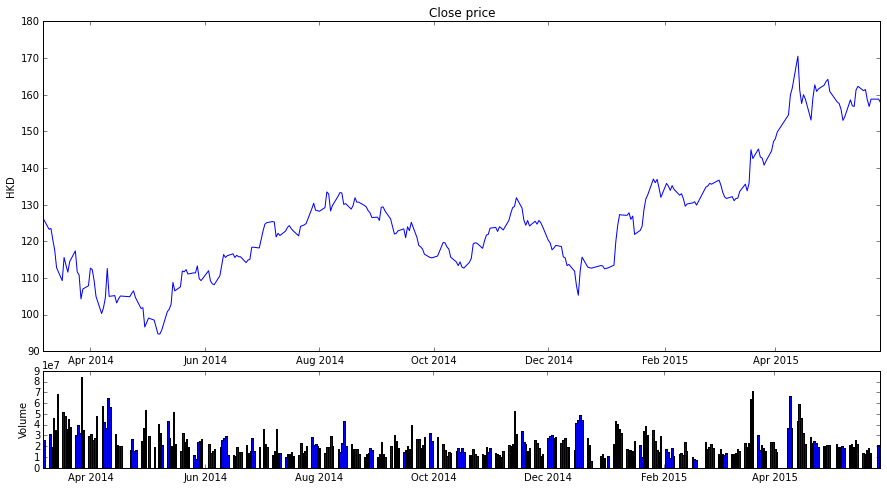

In [94]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4, ylabel='HKD')
top.plot(panel['BTC'].index, panel['BTC']["close"])
plt.title('Close price')

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4, ylabel='Volume')
bottom.bar(panel['BTC'].index, panel['BTC']['volume'])

plt.gcf().set_size_inches(15,8)

In [95]:
dma = DualMovingAverage()
results = dma.run(panel)

2014-05-21 00:00:00+00:00: Buying 100 BTC shares.
2014-08-27 00:00:00+00:00: Selling 100 BTC shares.
2014-10-28 00:00:00+00:00: Buying 100 BTC shares.
2014-12-02 00:00:00+00:00: Selling 100 BTC shares.
2015-01-05 00:00:00+00:00: Buying 100 BTC shares.
2015-01-06 00:00:00+00:00: Selling 100 BTC shares.
2015-01-07 00:00:00+00:00: Buying 100 BTC shares.
2015-02-18 00:00:00+00:00: Selling 100 BTC shares.
2015-03-03 00:00:00+00:00: Buying 100 BTC shares.
2015-03-16 00:00:00+00:00: Selling 100 BTC shares.
2015-03-20 00:00:00+00:00: Buying 100 BTC shares.
2015-05-08 00:00:00+00:00: Selling 100 BTC shares.
2015-05-22 00:00:00+00:00: Buying 100 BTC shares.

[2015-05-28 10:19:33.517318] INFO: Performance: Simulated 306 trading days out of 308.
[2015-05-28 10:19:33.517950] INFO: Performance: first open: 2014-03-07 14:31:00+00:00
[2015-05-28 10:19:33.518465] INFO: Performance: last close: 2015-05-27 20:00:00+00:00


In [56]:
# fig = plt.figure()
# ax1 = fig.add_subplot(211, ylabel='portfolio value')
# results.tail()
# results is daily so we might have to resample our original data to plot it on the same graph
# and for some reason results short_mavg and long_mavg are each at 20:00 or 21:00 so we offest the resampling
# there is some mystery here
# offset = datetime.timedelta(hours = 21)
# panel['BTC']['open'].resample('1D', loffset=offset).plot(ax=ax2, color='r')

# results[['short_mavg', 'long_mavg']].plot(ax=ax2)

# ax2.plot(results.ix[results.buy].index, results.short_mavg[results.buy],'^', markersize=10, color='m')
# ax2.plot(results.ix[results.sell].index, results.short_mavg[results.sell],'v', markersize=10, color='k')
# plt.legend(loc=0)
# plt.show()

,buy,capital_used,ending_cash,ending_value,long_mavg,orders,period_close,period_open,pnl,portfolio_value,positions,returns,sell,short_mavg,starting_cash,starting_value,transactions
2015-05-18 20:00:00,False,0,91466.799995,7515,74.705263,[],2015-05-18 20:00:00+00:00,2015-05-18 13:31:00+00:00,-50,98981.799995,"[{u'amount': 100, u'last_sale_price': 75.15, u...",-0.000505,False,75.300,91466.799995,7565,[]
2015-05-19 20:00:00,False,0,91466.799995,7465,74.918421,[],2015-05-19 20:00:00+00:00,2015-05-19 13:31:00+00:00,-50,98931.799995,"[{u'amount': 100, u'last_sale_price': 74.65, u...",-0.000505,False,75.195,91466.799995,7515,[]
2015-05-20 20:00:00,False,0,91466.799995,7460,75.118421,[],2015-05-20 20:00:00+00:00,2015-05-20 13:31:00+00:00,-5,98926.799995,"[{u'amount': 100, u'last_sale_price': 74.6, u'...",-0.000051,False,75.220,91466.799995,7465,[]
2015-05-21 20:00:00,False,0,91466.799995,7425,75.300000,"[{u'status': 0, u'created': 2015-05-21 00:00:0...",2015-05-21 20:00:00+00:00,2015-05-21 13:31:00+00:00,-35,98891.799995,"[{u'amount': 100, u'last_sale_price': 74.25, u...",-0.000354,True,75.195,91466.799995,7460,[]
2015-05-22 20:00:00,False,7512,98978.799995,0,75.478947,"[{u'status': 1, u'created': 2015-05-21 00:00:0...",2015-05-22 20:00:00+00:00,2015-05-22 13:31:00+00:00,87,98978.799995,[],0.000880,False,75.110,91466.799995,7425,"[{u'commission': 3.0, u'amount': -100, u'sid':..."


In [81]:
from zipline.finance import trading
from zipline.utils.factory import create_returns_from_list
from zipline.finance.risk import RiskReport

In [99]:

start = results.first_valid_index().replace(tzinfo=pytz.utc)
end = results.last_valid_index().replace(tzinfo=pytz.utc)

env = trading.SimulationParameters(start, end)
returns_risk = create_returns_from_list(results, env)
# risk = RiskReport(results.returns,env)
help(zipline.finance.risk)
# print risk

ValueError: cannot copy sequence with size 17 to array axis with dimension 306